In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
!git clone https://github.com/Depersonalizc/vce-patho-discovery.git

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/content/vce-patho-discovery')

Cloning into 'vce-patho-discovery'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 190 (delta 10), reused 12 (delta 10), pack-reused 175
Receiving objects: 100% (190/190), 3.44 MiB | 23.18 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [ ]:
!cp -r /content/gdrive/Shareddrives/c012-153/data/kvasir_seg.zip /content/
!cp -r /content/gdrive/Shareddrives/c012-153/data/vce_polyp.zip /content/
!cp -r /content/gdrive/Shareddrives/c012-153/data/ProcessedVcePolyp.zip /content/

!mkdir /content/data
!unzip /content/kvasir_seg.zip -d /content/data/
!unzip /content/vce_polyp.zip -d /content/data/
!unzip /content/ProcessedVcePolyp.zip -d /content/data/vce_polyp_eval

Archive:  /content/kvasir_seg.zip
   creating: /content/data/kvasir_seg/
   creating: /content/data/kvasir_seg/Kvasir-SEG/
  inflating: /content/data/kvasir_seg/Kvasir-SEG/kavsir_bboxes.json  
   creating: /content/data/kvasir_seg/Kvasir-SEG/images/
  inflating: /content/data/kvasir_seg/Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg  
  inflating: /content/data/kvasir_seg/Kvasir-SEG/images/ck2bxknhjvs1x0794iogrq49k.jpg  
  inflating: /content/data/kvasir_seg/Kvasir-SEG/images/ck2bxlujamu330725szlc2jdu.jpg  
  inflating: /content/data/kvasir_seg/Kvasir-SEG/images/ck2bxpfgxu2mk0748gsh7xelu.jpg  
  inflating: /content/data/kvasir_seg/Kvasir-SEG/images/ck2bxqz3evvg20794iiyv5v2m.jpg  
  inflating: /content/data/kvasir_seg/Kvasir-SEG/images/ck2bxskgxxzfv08386xkqtqdy.jpg  
  inflating: /content/data/kvasir_seg/Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg  
  inflating: /content/data/kvasir_seg/Kvasir-SEG/images/ck2395w2mb4vu07480otsu6tw.jpg  
  inflating: /content/data/kvasir_seg/Kvasir-S

In [ ]:
!python3 vce-patho-discovery/scripts/preprocess.py

Total Size:  1000
Training Size:  800
Validation Size:  100
Testing Size:  100
100% 100/100 [00:01<00:00, 91.90it/s]
100% 100/100 [00:01<00:00, 98.16it/s]
100% 800/800 [23:33<00:00,  1.77s/it]


In [ ]:
!cp vce-patho-discovery/data/rupp.py vce-patho-discovery/data/da.py

In [ ]:
import os
import os.path as osp
import random
from glob import glob
from itertools import cycle

import numpy as np
from tqdm.notebook import tqdm, trange

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms as T
from torchvision.transforms import functional as TF

from models import ResUnetPlusPlus, get_fc_discriminator
from utils.training import BinaryEntropy, poly_lr_scheduler
from data import RUPP, ADVENT, RandomFlip, RandomSE2

In [ ]:
src_dir = '/content/data/kvasir_seg/Kvasir-SEG/'
tgt_dir = '/content/data/vce_polyp/'
tgt_eval_dir = '/content/data/vce_polyp_eval/'
tsfm = {
    'src': 
    {
        'img': T.Compose([
                    T.ToTensor(),
                    T.Resize((256, 256)),
                ]),
        'mask': T.Compose([
                    T.ToTensor(),
                    T.Resize((256, 256), 
                             interpolation=T.InterpolationMode.NEAREST),
                ]),
        'pair': T.Compose([
                    RandomFlip(),
                    RandomSE2(180, 0.1, 0.1)
                ]),
    },

    'tgt': 
    {
        'train': 
        {
            'img': T.Compose([
                        T.ToTensor(),
                        T.Resize((256, 256)),

                        # aug-DA
                        T.RandomHorizontalFlip(),
                        T.RandomVerticalFlip(),
                        T.RandomAffine(180, (0.1, 0.1))

                   ]),
        },

        'val':
        {
            'img': T.Compose([
                        T.ToTensor(),
                        T.Resize((256, 256)),
                   ]),
            'mask': T.Compose([
                        T.ToTensor(),
                        T.Resize((256, 256), 
                                interpolation=T.InterpolationMode.NEAREST),
                    ]),
            'pair': None,
        },

        'test':
        {
            'img': T.Compose([
                        T.ToTensor(),
                        T.Resize((256, 256)),
                   ]),
            'mask': T.Compose([
                        T.ToTensor(),
                        T.Resize((256, 256), 
                                interpolation=T.InterpolationMode.NEAREST),
                    ]),
            'pair': None,
        }
    }
}

src_set = ADVENT(root_dir=src_dir, transform=tsfm['src'])
tgt_set_train = ADVENT(root_dir=tgt_dir,
                       transform=tsfm['tgt']['train'],
                       get_mask=False)
tgt_set_val = ADVENT(root_dir=tgt_eval_dir,
                     transform=tsfm['tgt']['val'])


1000it [00:02, 418.54it/s]
1000it [00:00, 1317.22it/s]


Found 1000 samples.


172it [00:00, 799.82it/s]


Found 172 samples.


104it [00:00, 805.61it/s]
104it [00:00, 1981.82it/s]

Found 104 samples.


In [ ]:
x, y = src_set[10]

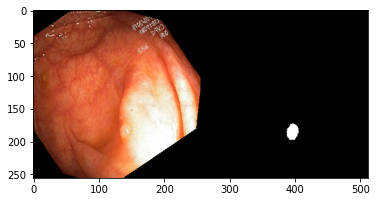

In [ ]:
import matplotlib.pyplot as plt
# plt.imshow(x.movedim(0, -1))
plt.imshow(torch.cat([x.movedim(0, -1),
                      y.movedim(0, -1).repeat(1, 1, 3)
                      ], 1)
)

In [ ]:
# trainer

class MinEntTrainer:
    """Min-entropy Domain Adaptation (binary entropy regularization)
    """
    def __init__(self, model,
                 train_loader, tgt_loader, val_loader,
                 iters, val_every,
                 optimizer, scheduler=None,
                 lambda_seg=1.0, lambda_ent=0.001,
                 device='cuda', seed=42, ckpt_from=None, ckpt_to='./ckpt'):
        self.model = model
        self.train_loader = cycle(iter(train_loader))
        self.tgt_loader = cycle(iter(tgt_loader))
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.iters = iters
        self.val_every = val_every
        self.lambda_seg = lambda_seg
        self.lambda_ent = lambda_ent
        self.device = device
        self.seed = seed
        self.ckpt_to = ckpt_to
        self.loss_seg = nn.BCELoss(
            # weight=torch.tensor([1.0, 8.0], device=self.device)
        )
        self.loss_ent = BinaryEntropy()

        self.iter = 0
        self.best_dice = 0.0
        self.best_iter = None

        self.model.to(self.device)
        if ckpt_from is not None:
            self.load_ckpt(ckpt_from)
        self.seed_everything()

    def fit(self):
        tq = trange(self.iters)
        for _ in tq:
            losses = self.train_iter()
            if self.iter % self.val_every == 1:
                self.val_dice()

            tq.set_description(f'train loss: {losses["loss"]:.5f}, '
                               f'loss_seg: {losses["loss_seg"]:.5f}, '
                               f'loss_ent: {losses["loss_ent"]:.5f}, '
                               f'best_dice: {self.best_dice:.4f} @iter {self.best_iter}')


    def train_iter(self):
        self.iter += 1
        self.model.train()

        # src, segmentation loss
        x, y = next(self.train_loader)
        x = x.to(self.device)
        y = y.to(self.device)
        pred = self.model(x)
        loss_seg = self.loss_seg(pred, y)

        # tgt, entropy loss
        x = next(self.tgt_loader)
        x = x.to(self.device)
        pred = self.model(x)
        loss_ent = self.loss_ent(pred)

        loss = (self.lambda_seg * loss_seg +
                self.lambda_ent * loss_ent)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.scheduler is not None:
            self.scheduler.step()

        ret = {'loss'    : loss.item(),
               'loss_seg': loss_seg.item(),
               'loss_ent': loss_ent.item()}
        return ret

    def val_dice(self, return_preds=False, val_only=False):
        """Calculate Dice score on all validation samples
        """
        self.model.eval()
        with torch.no_grad():
            nume = 0
            deno = 0
            preds = []
            for x, y in self.val_loader:
                x = x.to(device)
                y = y.to(device) > 0.5
                pred = self.model(x) # (B, 1, h, w)
                mask = pred > 0.5
                nume += torch.count_nonzero(mask & y).item()
                deno += (torch.count_nonzero(mask) + torch.count_nonzero(y)).item()
                if return_preds:
                    preds.append([x.detach().cpu().float(),
                                  y.detach().cpu().float(),
                                  mask.detach().cpu().float()])
            dice = 2 * nume / deno
            if dice > self.best_dice and not val_only:
                self.best_dice = dice
                self.best_iter = self.iter
                if self.best_dice > 0.7:
                    self.save_model()
            print(f'[Iter {self.iter}/{self.iters}], '
                  f'Val Dice: {dice:.4f}, '
                  f'Best: {self.best_dice:.4f} @iter {self.best_iter}')
            if return_preds:
                return preds

    def load_ckpt(self, ckpt_dir):
        try:
            self.model.load_state_dict(torch.load(ckpt_dir))
        except Exception as e:
            print(e)
        else:
            print(f'Loaded ckpt from {ckpt_dir}')

    def seed_everything(self):
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        np.random.seed(self.seed)

    def save_model(self):
        os.makedirs(self.ckpt_to, exist_ok=True)
        name = f'I{self.best_iter}_dice={self.best_dice:4f}.pt'
        path = osp.join(self.ckpt_to, name)
        torch.save(self.model.state_dict(), path)
        print(f'!NEW CHECKPOINT! saved at {path}')

    def load_best(self):
        ckpt = glob(osp.join(self.ckpt_to, f'{self.best_iter}*.pt'))[0]
        self.load_ckpt(ckpt)



In [ ]:
## spec
device = 'cuda'
seed = 42

## model
model = ResUnetPlusPlus(3)
# model.to(device)

## datasets
# train_set = RUPP(root_dir='/content/data/kvasir_seg_new/Kvasir-SEG/', split='train')
# val_set = RUPP(root_dir='/content/data/kvasir_seg_new/Kvasir-SEG/', split='valid')

## training
ckpt_from = '/content/gdrive/Shareddrives/c012-153/ckpt/ResUnet++/E271_dice=0.820093_testdice=0.8184.pt'
# ckpt_from = '/content/gdrive/Shareddrives/c012-153/ckpt/ResUnet++_MinEnt/I6551_dice=0.715479.pt'

iters = 10000
val_every = 50
lambda_seg = 1.0
lambda_ent = 0.001
batch_size = 8
train_loader = DataLoader(src_set, batch_size=batch_size, shuffle=True)
tgt_loader = DataLoader(tgt_set_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(tgt_set_val, batch_size=16, shuffle=False)

g_lr = 2.5e-4
d_lr = 1.0e-4
power = 0.9
optimizer = torch.optim.Adam(model.parameters(), lr=1)
scheduler = poly_lr_scheduler(optimizer, g_lr, iters, power, 
                              last_epoch=-1)
 
trainer = MinEntTrainer(model=model, 
                        train_loader=train_loader, tgt_loader=tgt_loader, val_loader=val_loader,
                        iters=iters, val_every=val_every,
                        lambda_seg=lambda_seg, lambda_ent=lambda_ent,
                        optimizer=optimizer, scheduler=scheduler,
                        ckpt_from=ckpt_from, ckpt_to='./ckpt',
                        device=device, seed=seed)

Loaded ckpt from /content/gdrive/Shareddrives/c012-153/ckpt/ResUnet++/E271_dice=0.820093_testdice=0.8184.pt


In [ ]:
!cp /content/ckpt/I2651_dice\=0.720011.pt /content/gdrive/Shareddrives/c012-153/ckpt/ResUnet++_MinEnt/both_aug/

In [ ]:
trainer.fit()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Iter 1/10000], Val Dice: 0.6848, Best: 0.6848 @iter 1
[Iter 51/10000], Val Dice: 0.6879, Best: 0.6879 @iter 51
!NEW CHECKPOINT! saved at ./ckpt/I101_dice=0.703025.pt
[Iter 101/10000], Val Dice: 0.7030, Best: 0.7030 @iter 101
[Iter 151/10000], Val Dice: 0.6747, Best: 0.7030 @iter 101
[Iter 201/10000], Val Dice: 0.6837, Best: 0.7030 @iter 101
[Iter 251/10000], Val Dice: 0.6768, Best: 0.7030 @iter 101
[Iter 301/10000], Val Dice: 0.6876, Best: 0.7030 @iter 101
[Iter 351/10000], Val Dice: 0.6057, Best: 0.7030 @iter 101
[Iter 401/10000], Val Dice: 0.6530, Best: 0.7030 @iter 101
!NEW CHECKPOINT! saved at ./ckpt/I451_dice=0.716964.pt
[Iter 451/10000], Val Dice: 0.7170, Best: 0.7170 @iter 451
[Iter 501/10000], Val Dice: 0.7124, Best: 0.7170 @iter 451
[Iter 551/10000], Val Dice: 0.6969, Best: 0.7170 @iter 451
[Iter 601/10000], Val Dice: 0.6910, Best: 0.7170 @iter 451
[Iter 651/10000], Val Dice: 0.6854, Best: 0.7170 @iter 451
!NEW CHECKPOINT! saved at ./ckpt/I701_dice=0.719610.pt
[Iter 701/10000

In [ ]:
!cp -r /content/ckpt /content/gdrive/Shareddrives/c012-153/ckpt/ResUnet++_MinEnt/

In [ ]:
!cp /content/ckpt/E17* /content/gdrive/Shareddrives/c012-153/ckpt/ResUnet++/

In [ ]:
# trainer.load_best()
trainer.load_ckpt('ckpt/I2651_dice=0.720011.pt')

Loaded ckpt from ckpt/I2651_dice=0.720011.pt


In [ ]:
preds = trainer.val_dice(return_preds=True, val_only=True)  # [(1, 1, H, W)], float

[Iter 0/10000], Val Dice: 0.6929, Best: 0.0000 @iter None


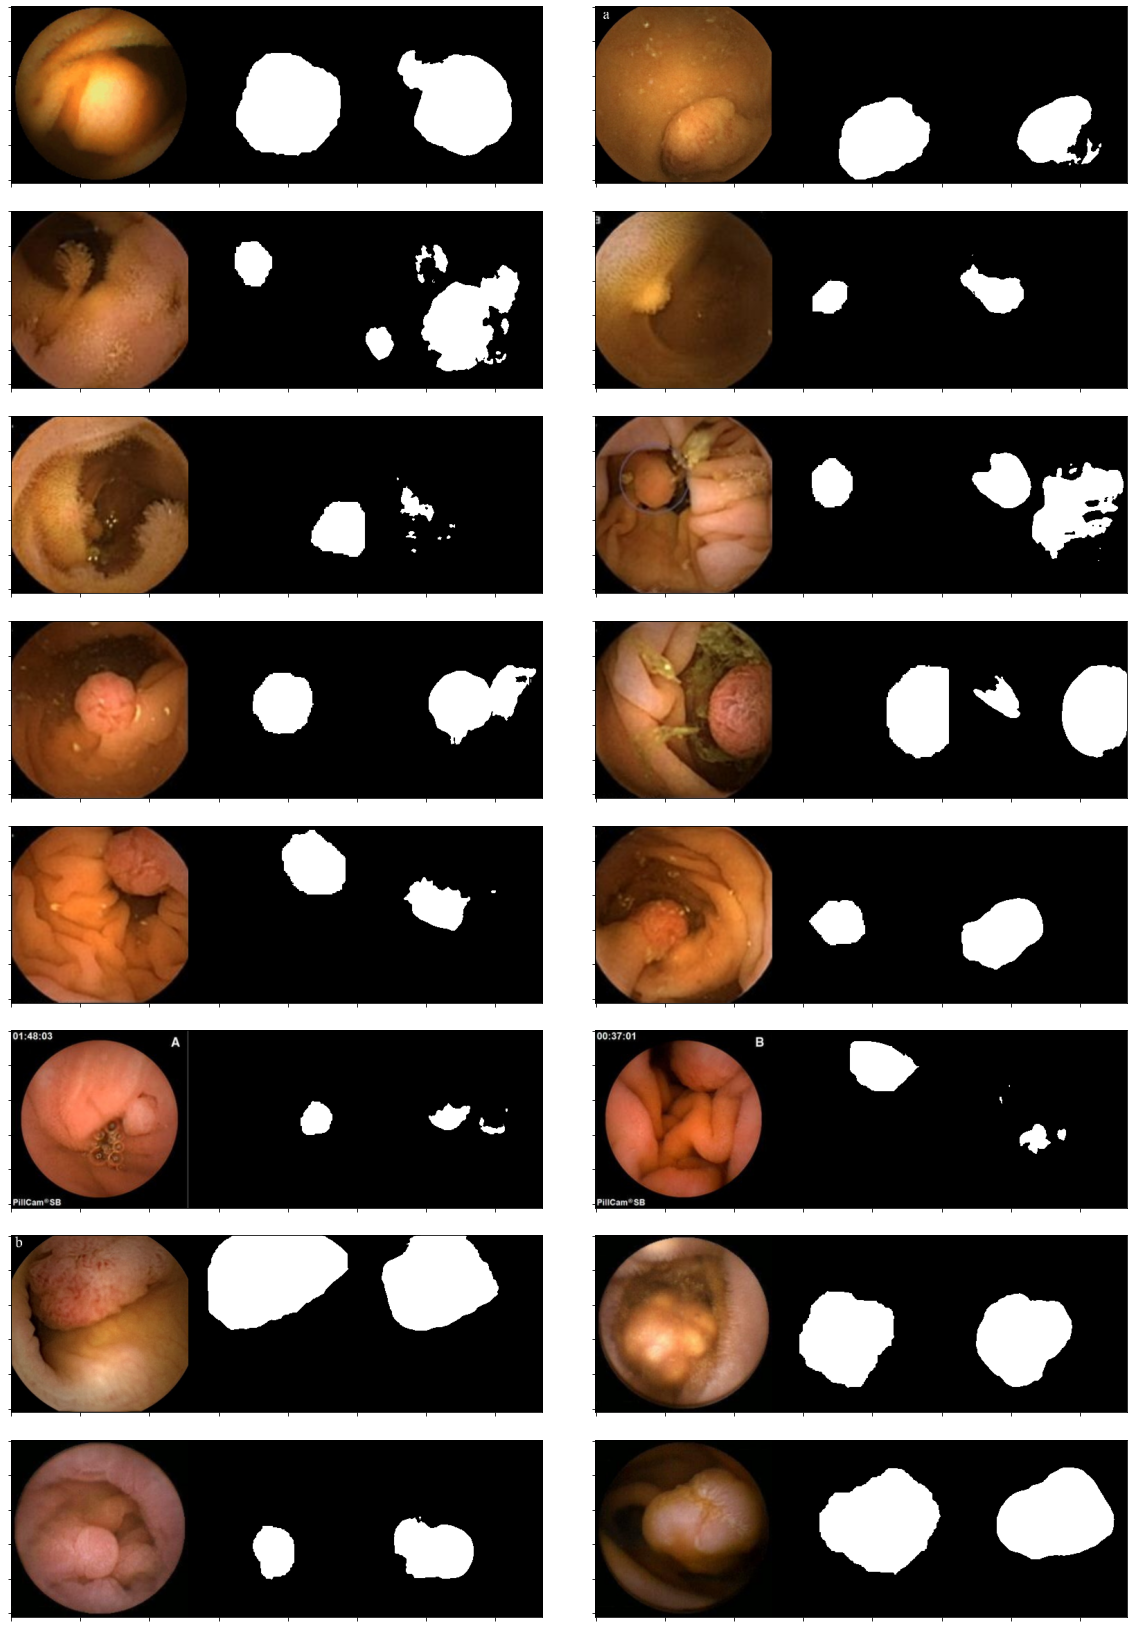

In [ ]:
# visualize result
import matplotlib.pyplot as plt

rows = 8
cols = 2
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 30))
fig.subplots_adjust(hspace=0.04, wspace=0.1)


batch_idx = 0
for i, (img, mask, pred) in enumerate(zip(*preds[batch_idx])):

    img = img.movedim(0, -1).numpy()
    mask = mask.movedim(0, -1).numpy()
    pred = pred.movedim(0, -1).numpy()  # (H, W, 1) float

    mask = np.repeat(mask, 3, -1)
    pred = np.repeat(pred, 3, -1)  # (H, W, 3) float

    vis = np.concatenate([img, mask, pred], 1)
    # vis = np.repeat(vis[..., None], 3, -1)

    row, col = divmod(i, cols)
    ax[row, col].imshow(vis)
    ax[row, col].set_xticklabels([])
    ax[row, col].set_yticklabels([])


In [ ]:
x, y, pred = preds[0]

In [ ]:
pred.shape

torch.Size([16, 1, 256, 256])

In [ ]:
%cd /content/vce-patho-discovery/

!git config --global user.email "1046770165@qq.com"
!git config --global user.name "Depersonalizc"
!git remote set-url origin 'https://token@github.com/Depersonalizc/vce-patho-discovery.git'

!git add .
!git status
!git commit -m 'yee'

!git push

/content/vce-patho-discovery
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   utils/training.py

[main 891c1b0] yee
 1 file changed, 7 insertions(+), 2 deletions(-)
Counting objects: 4, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 480 bytes | 480.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Depersonalizc/vce-patho-discovery.git
   829cbef..891c1b0  main -> main
